In [1]:
from __future__ import print_function
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import tqdm_notebook, tqdm, trange
print(torch.__version__)

1.0.0.dev20181017


In [2]:
batch_size = 1024

train_loader = torch.utils.data.DataLoader(
                    datasets.MNIST('../data', train=True, download=True,
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))])),
                    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
                    datasets.MNIST('../data', train=False, 
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))])),
                    batch_size=batch_size, shuffle=True)

In [3]:
# Declare Neural Network Layer
weights1 = torch.randn((784, 500), dtype=torch.float32, requires_grad=True)
weights2 = torch.randn((500, 250), dtype=torch.float32, requires_grad=True)
weights3 = torch.randn((250, 10), dtype=torch.float32, requires_grad=True)

# Build forward / loss / one-hot function
def forward(data, weights):

    trace = dict()
    length = len(weights)
    
    out = data
    for i in range(length - 1):
        out = torch.matmul(out, weights[i])
        trace["z{}".format(i+1)] = out
        out = torch.sigmoid(out)
        trace["a{}".format(i+1)] = out
    else:
        out = torch.matmul(out, weights[-1])
        trace["z3".format(i+1)] = out
    return out, trace

def mse(out, logits):
    n = out.shape[0]
    loss_matric = out - logits
    loss_matric = torch.mul(loss_matric, loss_matric)
    loss_matric = torch.sqrt(loss_matric)
    
    return torch.div(torch.sum(loss_matric), n)

def one_hot(batch,depth):
    ones = torch.eye(depth)
    return ones.index_select(0,batch)

def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook

def derivate_sigmoiod(data):
    return torch.sigmoid(data)*(1 - torch.sigmoid(data))

In [4]:
epoch = 10
total_bar_length = tqdm_notebook(range(epoch))
learning_rate = 0.00005
loss = 0

train_loss_hist = list()
test_loss_hist = list()

weights = [weights1, weights2, weights3]

for epoch in total_bar_length:
    
    if epoch == 7:
        learning_rate = 0.00002
    elif epoch == 20:
        learning_rate = 0.000008
    
    for batch_id, (data, target) in enumerate(train_loader):

        # Train
        batch, _, _, _ = data.shape
        data = data.view(batch, -1)
        target = one_hot(target, 10)

        out, trace = forward(data, weights)
        loss = mse(out, target)

        # Test
        if batch_id % 10 == 0 and batch_id != 0:
            test_data_iter = iter(test_loader)
            test_data, test_target = next(test_data_iter)
            test_batch, _, _, _ = test_data.shape
            test_data = test_data.view(test_batch, -1)
            test_target = one_hot(test_target, 10)

            test_out, _ = forward(test_data, weights)
            test_loss = mse(test_out, test_target)

            train_loss_hist.append(loss)
            test_loss_hist.append(test_loss)
            
        if batch_id % 25 == 0 and batch_id != 0:
            print("Epoch : {}, Step : {}, train_loss : {}, val_loss : {}".format(epoch, batch_id, loss, test_loss))

        grad_loss = torch.div(torch.mul(2.0, out-target), batch_size)
        grad_w3 = trace["a2"].t().mm(grad_loss)

        grad_a2 = derivate_sigmoiod(trace["z2"])
        grad_w2 = trace["a1"].t().mm(grad_a2)

        grad_a1 = derivate_sigmoiod(trace["z1"])
        grad_w1 = data.t().mm(grad_a1)

        log = False
        if log:
            print("------------------------------------------------")
            print("Loss : {}".format(loss))
            print("grad_w3:\t{}".format(grad_w3.shape))
            print("grad_w2:\t{}".format(grad_w2.shape))
            print("grad_w1:\t{}".format(grad_w1.shape))
            print(grad_w3)
            print(grad_w2)
            print(grad_w1)
            print("------------------------------------------------")

        weights[2] = weights[2] - (learning_rate * grad_w3)
        weights[1] = weights[1] - (learning_rate * grad_w2)
        weights[0] = weights[0] - (learning_rate * grad_w1)

Epoch : 0, Step : 25, train_loss : 58.258506774902344, val_loss : 60.44619369506836
Epoch : 0, Step : 50, train_loss : 51.07801818847656, val_loss : 50.56529235839844
Epoch : 1, Step : 25, train_loss : 45.86250305175781, val_loss : 46.20321273803711
Epoch : 1, Step : 50, train_loss : 41.965431213378906, val_loss : 41.567588806152344
Epoch : 2, Step : 25, train_loss : 38.91413497924805, val_loss : 38.9013786315918
Epoch : 2, Step : 50, train_loss : 37.82454299926758, val_loss : 37.81427001953125
Epoch : 3, Step : 25, train_loss : 37.117462158203125, val_loss : 37.294044494628906
Epoch : 3, Step : 50, train_loss : 36.916786193847656, val_loss : 36.36481475830078
Epoch : 4, Step : 25, train_loss : 36.22582244873047, val_loss : 36.70894241333008
Epoch : 4, Step : 50, train_loss : 36.46184539794922, val_loss : 35.855159759521484
Epoch : 5, Step : 25, train_loss : 36.16240692138672, val_loss : 35.73003387451172
Epoch : 5, Step : 50, train_loss : 36.24589538574219, val_loss : 36.3432693481445

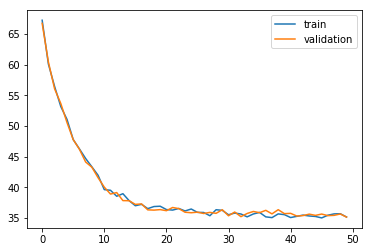

In [5]:
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="validation")
plt.legend()
plt.show()